Class Counts: {'wrinkles': 250, 'dark spots': 272, 'puffy eyes': 246, 'clear skin': 298}


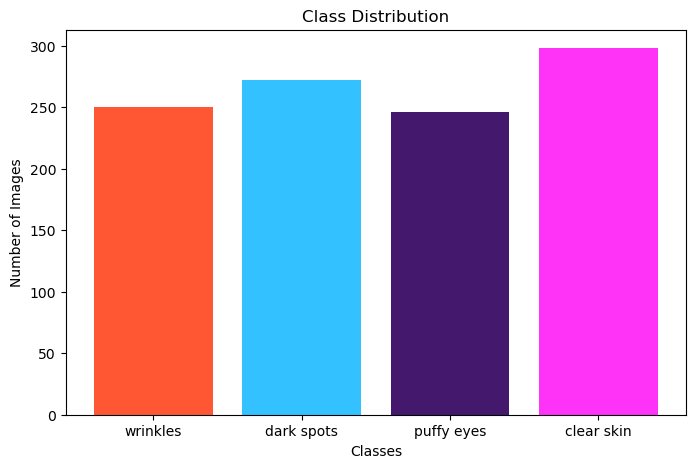

In [1]:
import os
import matplotlib.pyplot as plt

DATASET_DIR = "C:/Dermal_AI/DATASET"

CLASSES = ["wrinkles", "dark spots", "puffy eyes", "clear skin"]

def scan_dataset(dataset_dir=DATASET_DIR):
    class_counts = {}
    
    for cls in CLASSES:
        folder = os.path.join(dataset_dir, cls)
        
        count = len(os.listdir(folder))
        class_counts[cls] = count

    return class_counts

def plot_class_distribution(counts):
    plt.figure(figsize=(8,5))
    colors = ["#FF5733", "#33C1FF", "#44196D", "#FF33F8"]
    plt.bar(counts.keys(), counts.values(),color=colors)
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

if __name__ == "__main__":
    counts = scan_dataset()
    print("Class Counts:", counts)
    plot_class_distribution(counts)


In [2]:
import os

print(os.path.exists("C:/Dermal_AI/DATASET"))
print(os.listdir("C:/Dermal_AI/DATASET"))


True
['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [3]:
import os

DATASET_DIR = "dataset"
VALID_EXT = (".jpg", ".jpeg", ".png")

for root, dirs, files in os.walk(DATASET_DIR):
    for file in files:
        if not file.lower().endswith(VALID_EXT):
            path = os.path.join(root, file)
            print("Removing:", path)
            try:
                os.remove(path)
            except Exception as e:
                print("Could not remove:", path, e)


In this cell, we apply data augmentation to our training dataset using TensorFlow ImageDataGenerator. Augmentation helps improve model generalization by creating 
multiple transformed versions of the existing images.

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=0.2
)


train_gen = augmentation.flow_from_directory(
    "dataset",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = augmentation.flow_from_directory(
    "dataset",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)
print(train_gen.class_indices)



Found 854 images belonging to 4 classes.
Found 212 images belonging to 4 classes.
{'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}


The below Cell contain script to show the augemented Images generated from the training batch. This helps us visually verify that the augmentation is working 
correctly.

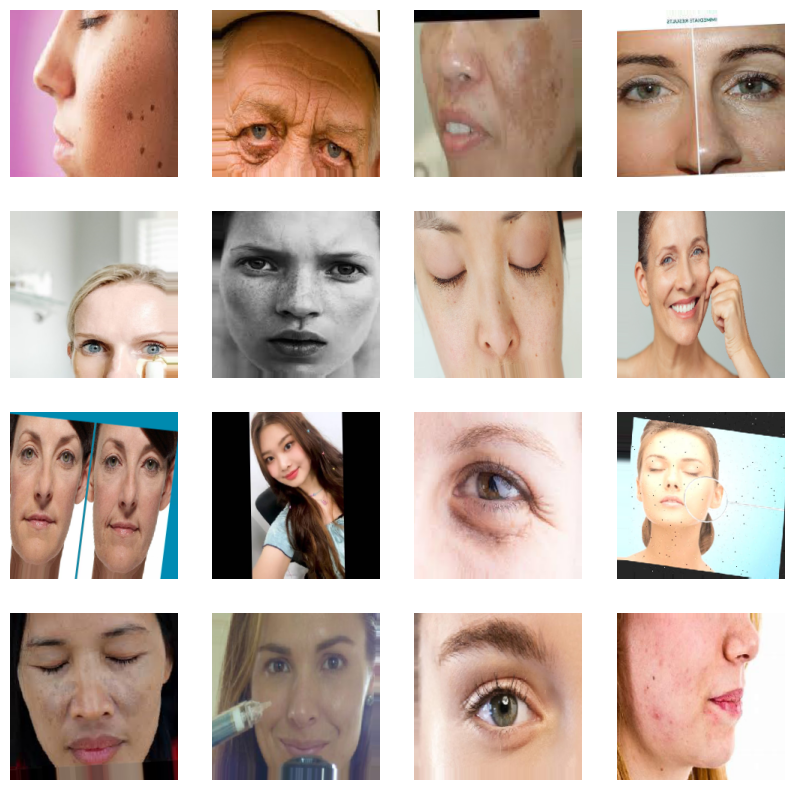

In [5]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(train_gen)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os


In [4]:
DATASET_DIR = "dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50   
NUM_CLASSES = 4


In [5]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [6]:
train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 854 images belonging to 4 classes.
Found 212 images belonging to 4 classes.


In [7]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [9]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [10]:
os.makedirs("models", exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.3,
        verbose=1
    ),
    ModelCheckpoint(
        "models/best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]


In [11]:
from PIL import Image
import os

DATASET_DIR = "dataset"
bad = []

for root, _, files in os.walk(DATASET_DIR):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(root, f)
            try:
                Image.open(p).verify()
            except:
                bad.append(p)

print("Bad images found:", len(bad))
for p in bad:
    os.remove(p)


Bad images found: 0


In [12]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2837 - loss: 1.6810
Epoch 1: val_loss improved from None to 1.11320, saving model to models/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.3349 - loss: 1.5005 - val_accuracy: 0.5142 - val_loss: 1.1132 - learning_rate: 1.0000e-04
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4542 - loss: 1.2755
Epoch 2: val_loss improved from 1.11320 to 0.92402, saving model to models/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.4742 - loss: 1.2214 - val_accuracy: 0.6509 - val_loss: 0.9240 - learning_rate: 1.0000e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5170 - loss: 1.1298
Epoch 3: val_loss improved from 0.92402 to 0.80484, saving model to models/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 941ms/step - accuracy: 0.5328 - loss: 1.0954 - val_accuracy: 0.7123 - val_loss: 0.8048 - learning_rate: 1.0000e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━

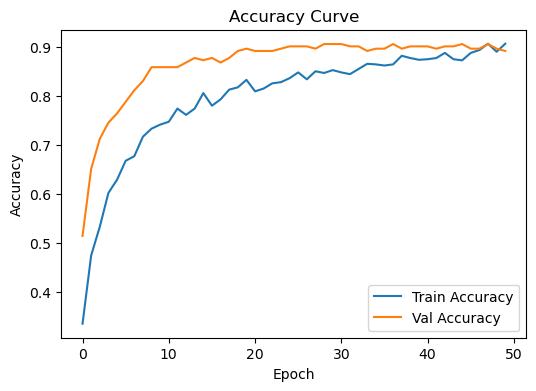

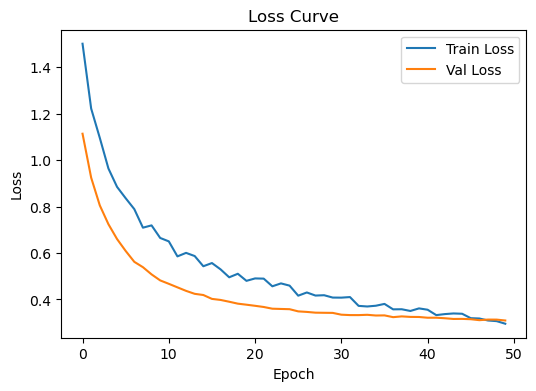

In [13]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


In [14]:
model.save("models/final_model.keras")


In [15]:
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc*100:.2f}%")
print(f"Validation Loss: {loss:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.8915 - loss: 0.3094
Validation Accuracy: 89.15%
Validation Loss: 0.3094


In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img(
    "C:/Dermal_AI/DATASET/wrinkles/1.jpg",
    target_size=(224, 224)
)
img = image.img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
class_name = list(train_gen.class_indices.keys())[np.argmax(pred)]

print("Predicted class:", class_name)
print("Confidence:", np.max(pred)*100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: wrinkles
Confidence: 89.31434


In [17]:
import cv2
print(cv2.__version__)


4.12.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


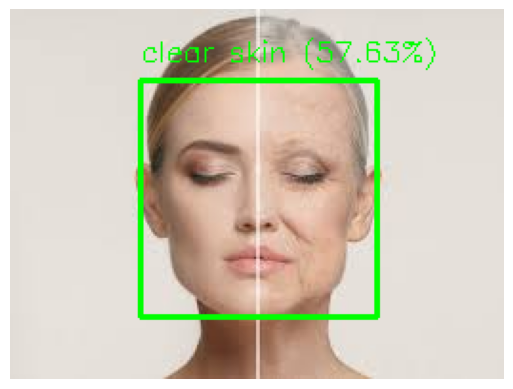

In [18]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load trained skin-condition model
skin_model = tf.keras.models.load_model(
    r"D:\Dermal_Ai\models\final_model.keras"
)

CLASSES = ["wrinkles", "dark spots", "puffy eyes", "clear skin"]

# Face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# Load image
img = cv2.imread(r"C:\Dermal_Ai\DATASET\wrinkles\1.jpg")

if img is None:
    raise FileNotFoundError("Image not found. Check the image path.")


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    face = face / 255.0
    face = np.expand_dims(face, axis=0)

    preds = skin_model.predict(face)
    label = CLASSES[np.argmax(preds)]

    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(img, label, (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    
preds = skin_model.predict(face)[0]

class_index = np.argmax(preds)
label = CLASSES[class_index]
confidence = preds[class_index] * 100

text = f"{label} ({confidence:.2f}%)"

cv2.putText(
    img, text, (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1
)
pad = int(0.15 * w)  # 15% padding
x1 = max(x + pad, 0)
y1 = max(y + pad, 0)
x2 = min(x + w - pad, img.shape[1])
y2 = min(y + h - pad, img.shape[0])

face = img[y1:y2, x1:x2]


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [19]:
import os
print(os.path.exists(r"D:\Dermal_Ai\models\final_model.keras"))


True


RestNet50 

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

NUM_CLASSES = 4
IMG_SIZE = (224, 224, 3)

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE
)

base_model.trainable = False  # freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

resnet_model = Model(inputs=base_model.input, outputs=outputs)

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
history_resnet = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2681 - loss: 1.7215 - val_accuracy: 0.4198 - val_loss: 1.3380
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 984ms/step - accuracy: 0.2705 - loss: 1.5762 - val_accuracy: 0.4151 - val_loss: 1.3071
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 986ms/step - accuracy: 0.3337 - loss: 1.4237 - val_accuracy: 0.4575 - val_loss: 1.2764
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 976ms/step - accuracy: 0.3571 - loss: 1.3733 - val_accuracy: 0.4292 - val_loss: 1.2630
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 985ms/step - accuracy: 0.3876 - loss: 1.3128 - val_accuracy: 0.4764 - val_loss: 1.2365
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 979ms/step - accuracy: 0.4204 - loss: 1.2647 - val_accuracy: 0.4009 - val_loss: 1.2334
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 972ms/step - accuracy: 0.4578 - loss: 1.2409 - val_accuracy: 0.5425 - val_loss: 1.2093
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 429s 8s/step - accuracy: 0.4836 - loss: 1.2275 - val_accuracy:

EfficientNetB0


In [22]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

NUM_CLASSES = 4
IMG_SIZE = (224, 224, 3)

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE
)

base_model.trainable = False  # freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

efficientnet_model = Model(inputs=base_model.input, outputs=outputs)

efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

efficientnet_model.summary()
history_efficientnet = efficientnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 749ms/step - accuracy: 0.2588 - loss: 1.4114 - val_accuracy: 0.2783 - val_loss: 1.3899
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 531ms/step - accuracy: 0.2283 - loss: 1.4130 - val_accuracy: 0.2783 - val_loss: 1.3830
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 489ms/step - accuracy: 0.2506 - loss: 1.3921 - val_accuracy: 0.2783 - val_loss: 1.3858
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - accuracy: 0.2447 - loss: 1.3966 - val_accuracy: 0.2547 - val_loss: 1.3838
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - accuracy: 0.2482 - loss: 1.3948 - val_accuracy: 0.2783 - val_loss: 1.3846
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 471ms/step - accuracy: 0.2600 - loss: 1.3942 - val_accuracy: 0.2783 - val_loss: 1.3836
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 472ms/step - accuracy: 0.2705 - loss: 1.3884 - val_accuracy: 0.2783 - val_loss: 1.3829
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 467ms/step - accuracy: 0.2752 - loss: 1.3877 - val_accu

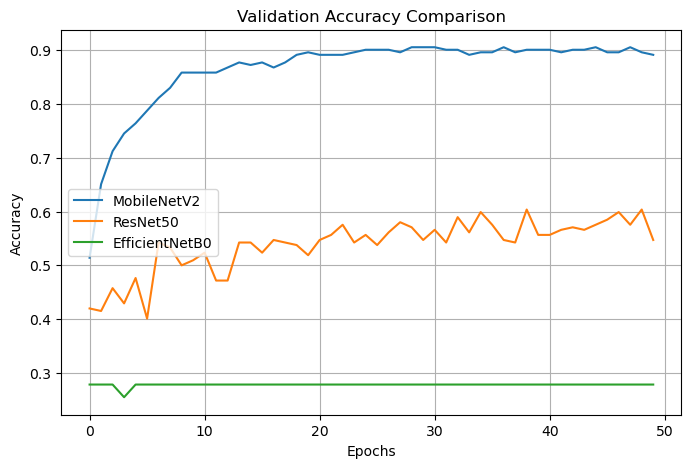

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(history.history['val_accuracy'], label='MobileNetV2')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50')
plt.plot(history_efficientnet.history['val_accuracy'], label='EfficientNetB0')

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


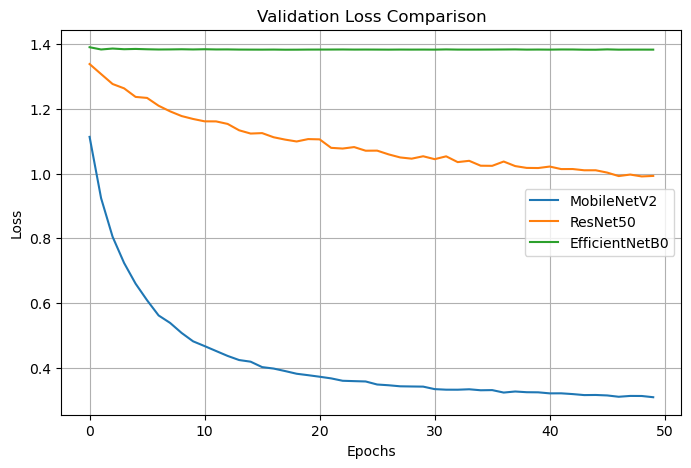

In [26]:
plt.figure(figsize=(8,5))

plt.plot(history.history['val_loss'], label='MobileNetV2')
plt.plot(history_resnet.history['val_loss'], label='ResNet50')
plt.plot(history_efficientnet.history['val_loss'], label='EfficientNetB0')

plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


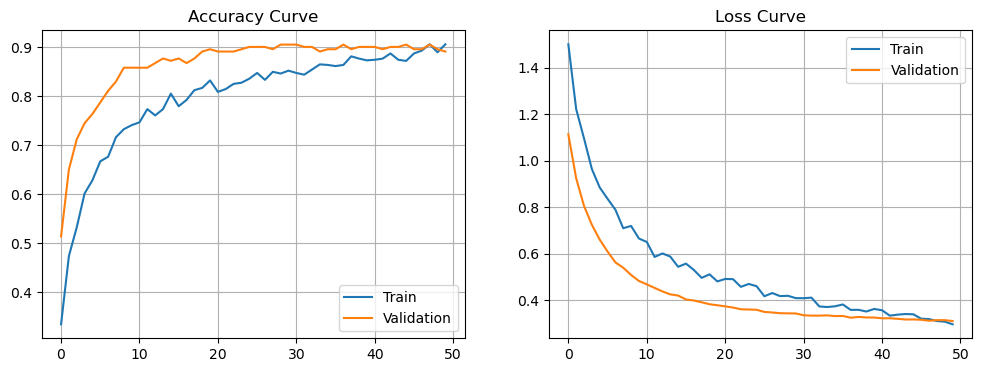

In [28]:
best_history = history  # change if another model performs better

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(best_history.history['accuracy'], label='Train')
plt.plot(best_history.history['val_accuracy'], label='Validation')
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(best_history.history['loss'], label='Train')
plt.plot(best_history.history['val_loss'], label='Validation')
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.show()
